In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import product
from tqdm.auto import tqdm
from datasets import available_datasets

sns.set_style('whitegrid')
sns.set_context("talk")
pd.set_option('display.width', 2000)

## Helper Functions

In [11]:
def read_logs(path, task, **params):
    df_results = pd.DataFrame()
    for config in tqdm(list(product(*params.values()))):
        experiment_file = os.path.join(
            path,
            f'task:{task}',
            *[f'{key}:{value}' for key, value in zip(params.keys(), config)],
            'metrics.csv'
        )
        df = pd.read_csv(experiment_file)
        for key, value in zip(params.keys(), config):
            df[key] = value
        df_results = df_results.append(df, ignore_index=True)
    return df_results


def export_figure(path, df, x, y, hue, col, error=None, prefix=''):
    if not os.path.exists(path):
        os.makedirs(path)
    
    if error is None:
        df = df.groupby([col, hue, x])[y].agg(['mean', np.std]).reset_index()
        output = [x, 'mean', 'std']
    else:
        output = [x, y, error]
        
    df['filename'] = df[[col, hue]].apply(
        lambda row: f'{prefix},' + ','.join(
            [f'{key}={val}' for key, val in row.iteritems()]
        ) + f',x={x},y={y}.txt', axis=1
    )
    df.groupby('filename').apply(
        lambda row: row[output].to_csv(
            os.path.join(path, row['filename'].unique().item()), 
            index=None, 
            sep=' '
        )
    )

In [3]:
results_path = 'results'
datasets = available_datasets()

## Analysis of the utility-privacy trade-off

In [4]:
epsilons = [0.1, 0.5, 1.0, 2.0]

df_lpgnn = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[1.0],
    method=['mbm'], 
    eps=epsilons,
    step=[1,2,4,8,16,32],
    agg=['gcn'],
    selfloops=[False],
)

df_gcn = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[1.0],
    method=['raw', 'rnd', 'ohd'], 
    eps=[0.0],
    step=[1],
    agg=['gcn'],
    selfloops=[True],
)


names = {
    'raw': '1-GCN+Raw',
    'mbm': '2-LPGNN',
    'rnd': '3-GCN+Rnd',
    'ohd': '4-GCN+Ohd',
    'cora': '1-Cora',
    'citeseer': '2-Citeseer',
    'pubmed': '3-Pubmed',
    'facebook': '4-Facebook',
    'github': '5-Github',
    'lastfm': '6-LastFM'
}

df_mean = df_lpgnn.groupby(['dataset', 'eps', 'step'])['test_acc'].mean().reset_index()
idx = df_mean.groupby(['dataset', 'eps'])['test_acc'].transform(max) == df_mean['test_acc']
df_max = df_mean[idx]
df_final = df_lpgnn.merge(df_max.drop(columns='test_acc'), on=['dataset', 'eps', 'step'], how='inner')
data = df_final.append(df_gcn, ignore_index=True)

data = data.groupby(['dataset', 'method', 'eps']).agg({'test_acc': ['mean', lambda x: np.std(x)]}).reset_index()
data = data.replace(names)
data.columns = ['Dataset', 'Method', '$\epsilon$', 'mean', 'std']
data['result'] = data[['mean', 'std']].apply(lambda row: '%.1f $\pm$~%.1f' % (row['mean'], row['std']), axis=1)
data = data.drop(columns=['mean', 'std']).set_index(['Dataset', 'Method', '$\epsilon$'])
data = data.unstack(level=0).T
data = data.rename(index=lambda name: name[2:] if name[1] == '-' else name)
data = data.rename(columns=lambda name: name[2:] if str(name)[1] == '-' else name)
data.index = data.index.droplevel()
data
# print(data.to_latex(escape=False))

Method             GCN+Raw           LPGNN                                                         GCN+Rnd         GCN+Ohd
$\epsilon$             0.0             0.1             0.5             1.0             2.0             0.0             0.0
Dataset                                                                                                                   
Cora        85.2 $\pm$~0.5  84.5 $\pm$~0.6  84.5 $\pm$~0.4  84.5 $\pm$~0.5  84.8 $\pm$~0.5  77.6 $\pm$~1.0  57.7 $\pm$~0.7
Citeseer    73.7 $\pm$~0.5  68.3 $\pm$~0.6  68.2 $\pm$~0.9  68.1 $\pm$~0.5  68.1 $\pm$~0.8  52.8 $\pm$~8.9  37.6 $\pm$~0.9
Pubmed      86.8 $\pm$~0.3  82.7 $\pm$~0.2  82.5 $\pm$~0.2  82.3 $\pm$~0.2  82.3 $\pm$~0.2  56.3 $\pm$~1.8  63.0 $\pm$~0.9
Facebook    94.9 $\pm$~0.1  93.9 $\pm$~0.1  93.9 $\pm$~0.2  93.9 $\pm$~0.2  93.9 $\pm$~0.2  39.4 $\pm$~3.8  77.4 $\pm$~0.5
Github      86.7 $\pm$~0.1  86.1 $\pm$~0.1  86.1 $\pm$~0.1  86.1 $\pm$~0.2  86.0 $\pm$~0.1  74.3 $\pm$~0.0  83.7 $\pm$~0.1
LastFM      87.9 $\pm$~0.3  86.0 $\pm$~0.2  86.1 $\pm$~0.3  86.0 $\pm$~0.3  86.2 $\pm$~0.3  21.4 $\pm$~0.9  70.0 $\pm$~0.5

## Studying the effect of multi-bit mechanism

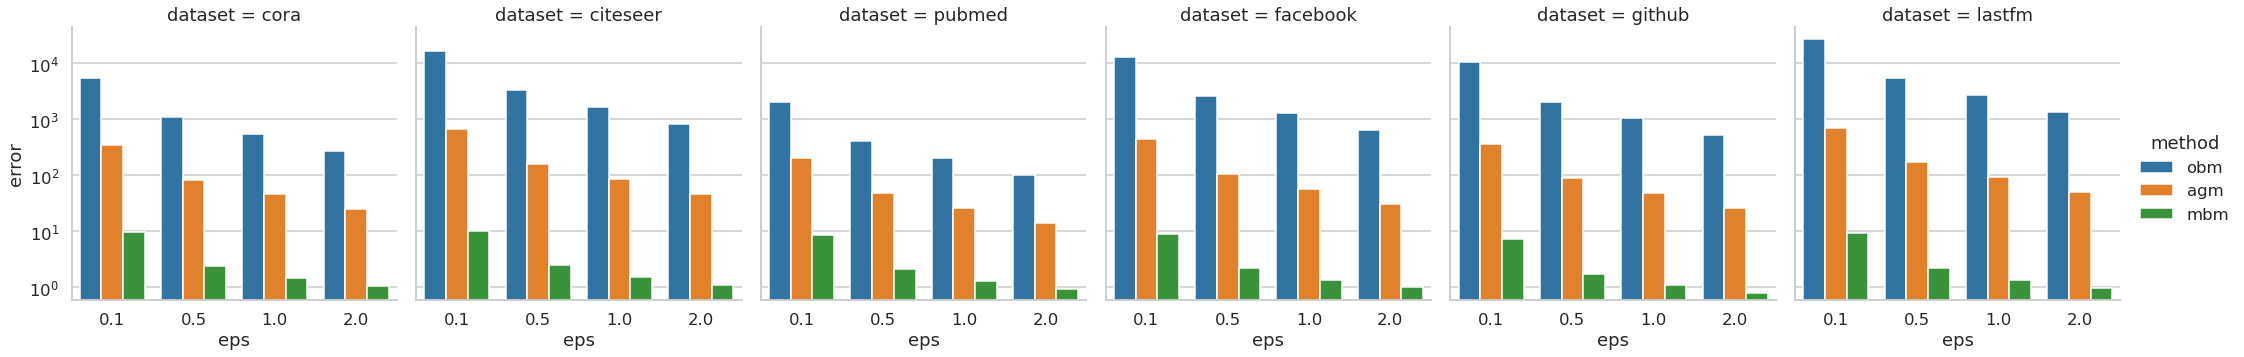

In [12]:
df_error = read_logs(
    path=results_path, 
    task='error', 
    dataset=datasets, 
    method=['obm', 'agm', 'mbm'], 
    eps=[0.1, 0.5, 1.0, 2.0], 
    agg=['gcn'], 
)

ax = sns.catplot(
    kind='bar', data=df_error, x='eps', y='error', hue='method', col='dataset', ci=None, sharey=True
)
ax.set(yscale='log')

export_figure(
    path='figures', df=df_error, x='eps', y='error', hue='method', 
    col='dataset', error='std', prefix='error'
)

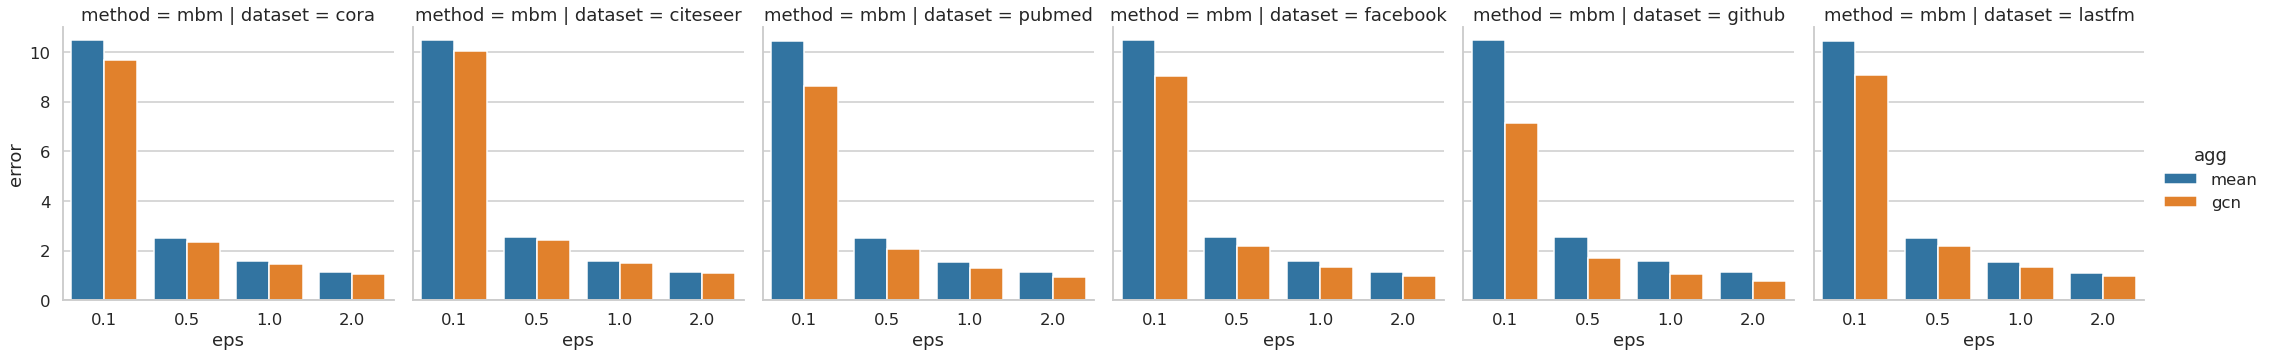

In [13]:
df_error = read_logs(
    path=results_path, 
    task='error', 
    dataset=datasets, 
    method=['mbm'], 
    eps=[0.1, 0.5, 1.0, 2.0], 
    agg=['mean', 'gcn'], 
)

ax = sns.catplot(
    kind='bar', data=df_error, x='eps', y='error', hue='agg', col='dataset', row='method', ci=None, sharey=True
)

export_figure(
    path='figures', df=df_error, x='eps', y='error', hue='agg', 
    col='dataset', error='std', prefix='error'
)

## Studying the effect of KProp

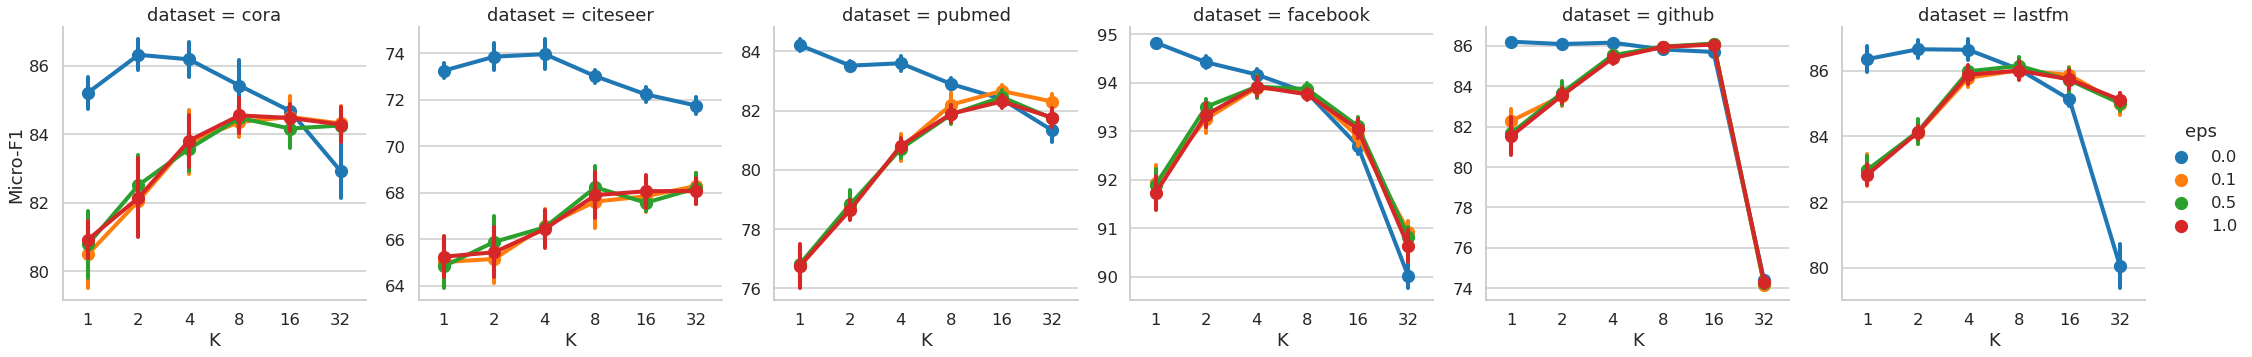

In [19]:
epsilons = [0.1, 0.5, 1.0]
hops = [1, 2, 4, 8, 16, 32]

df_lpgnn = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[1.0],
    method=['mbm'], 
    eps=epsilons,
    step=hops,
    agg=['gcn'],
    selfloops=[False],
)

df_gcn = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[1.0],
    method=['raw'], 
    eps=[0.0],
    step=hops,
    agg=['gcn'],
    selfloops=[False],
)

data = df_lpgnn.append(df_gcn, ignore_index=True)

ax = sns.catplot(
    kind='point', data=data, x='step', y='test_acc', hue='eps', col='dataset', ci='sd',
    sharex=False, sharey=False,
)

ax.set_ylabels('Micro-F1')
ax.set_xlabels('K')

export_figure(path='figures', df=data, x='step', y='test_acc', hue='eps', col='dataset', prefix='train')

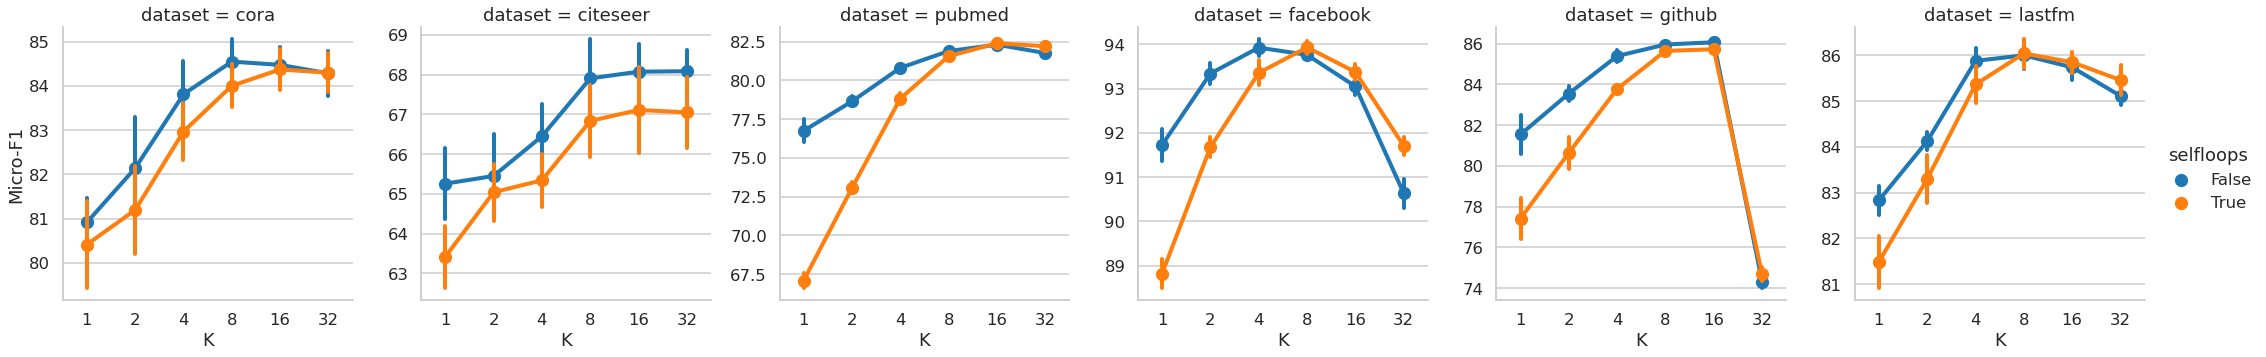

In [15]:
epsilons = [1.0]
hops = [1, 2, 4, 8, 16, 32]

data = read_logs(
    path=results_path,
    task='train',
    dataset=datasets,
    labelrate=[1.0],
    method=['mbm'], 
    eps=epsilons,
    step=hops,
    agg=['gcn'],
    selfloops=[False, True],
)

ax = sns.catplot(
    kind='point', data=data, x='step', y='test_acc', hue='selfloops', col='dataset', ci='sd',
    sharex=False, sharey=False,
)

ax.set_ylabels('Micro-F1')
ax.set_xlabels('K')

export_figure(path='figures', df=data, x='step', y='test_acc', hue='selfloops', col='dataset', prefix='train')

## Effect of label rate

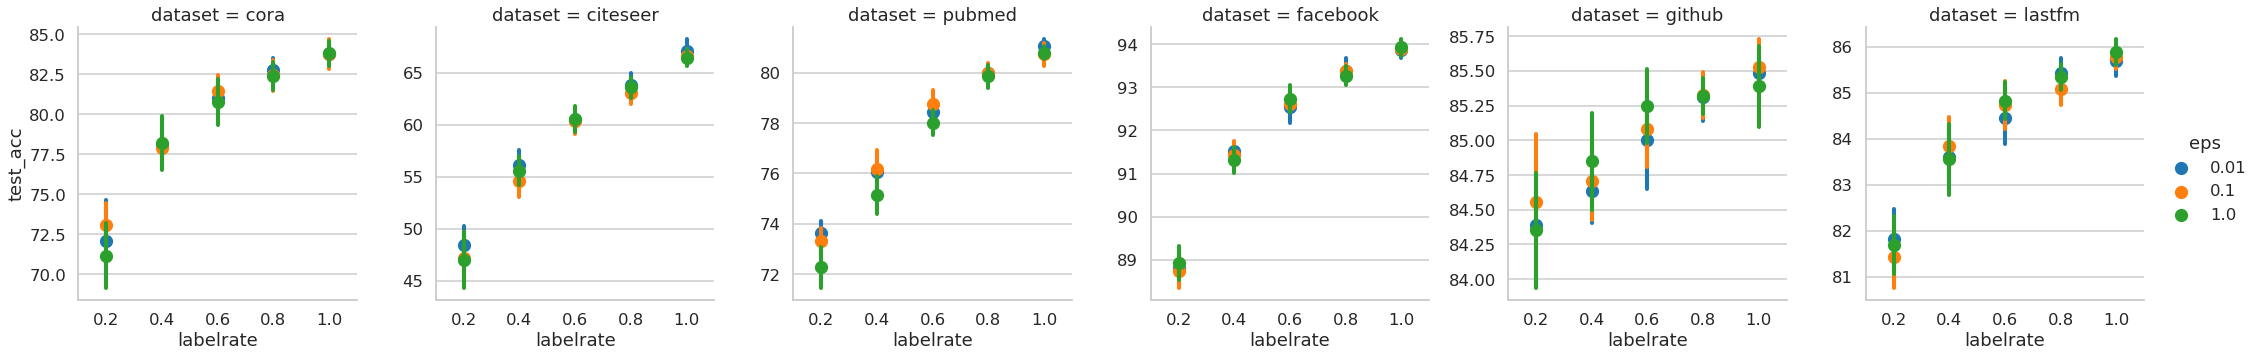

In [21]:
data = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[0.2, 0.4, 0.6, 0.8, 1.0],
    method=['mbm'], 
    eps=[0.01, 0.1, 1.0],
    step=[4],
    agg=['gcn'],
    selfloops=[False],
)

ax = sns.catplot(
    kind='point', data=data, x='labelrate', y='test_acc', hue='eps', col='dataset', ci='sd',
    sharex=False, sharey=False, join=False
)

export_figure(path='figures', df=data, x='labelrate', y='test_acc', hue='eps', col='dataset', prefix='train')

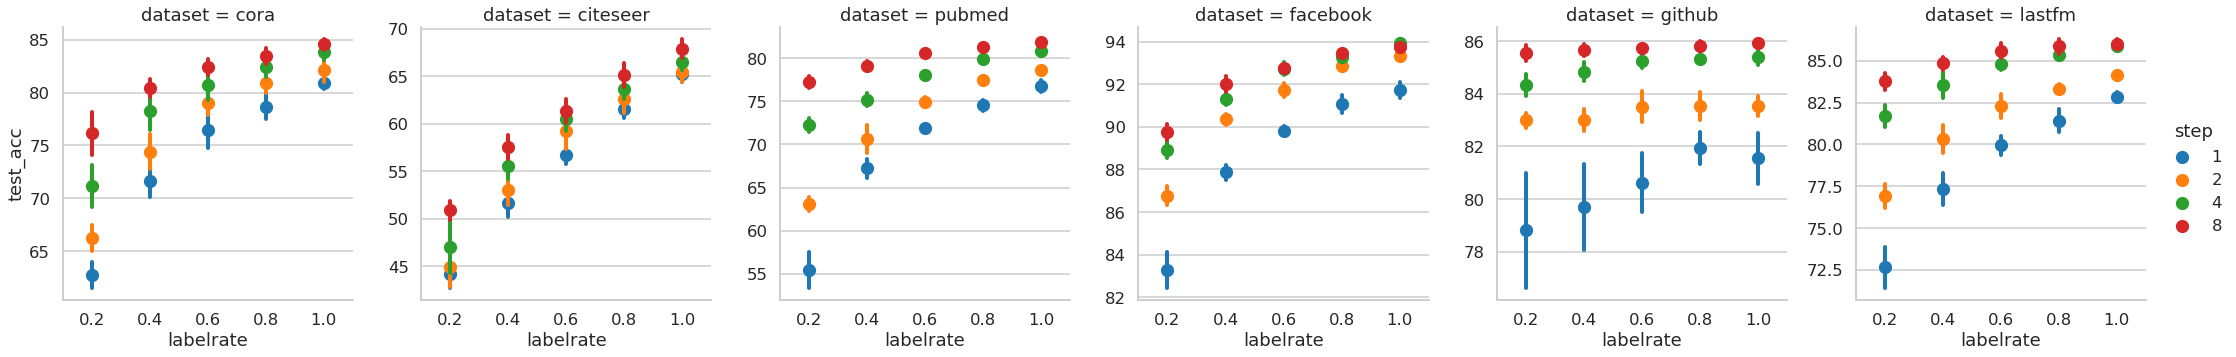

In [17]:
data = read_logs(
    path=results_path,
    task='train',
    dataset=datasets, 
    labelrate=[0.2, 0.4, 0.6, 0.8, 1.0],
    method=['mbm'], 
    eps=[1.0],
    step=[1, 2, 4, 8],
    agg=['gcn'],
    selfloops=[False],
)

ax = sns.catplot(
    kind='point', data=data, x='labelrate', y='test_acc', hue='step', col='dataset', ci='sd',
    sharex=False, sharey=False, join=False
)

export_figure(path='figures', df=data, x='labelrate', y='test_acc', hue='step', col='dataset', prefix='train')